In [1]:
# load libraries 
import pandas as pd 
import numpy as np 
import seaborn as sns
import os 
from pathlib import Path
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import textwrap

In [2]:
# Get current working directory
cwd = Path.cwd()

# Search for root directory
def find_root_directory(target_folder="TechnocraticDemocracies"):
    for parent in cwd.parents:
        if parent.name == target_folder:
            return parent
    return None

root_directory = find_root_directory()

if root_directory:
    print(f"Root directory found: {root_directory}")
    # Example of relative path creation
    relative_path = root_directory / "data"
    print(f"Relative path to 'data': {relative_path}")
else:
    print("Root directory not found.")

# Set raw data and output paths 
raw_data_dir = root_directory / '01 Raw Data'
plot_dir = root_directory / '04 Plots'
print(f"Path to raw data: {raw_data_dir}")
print(f"Path to plots: {plot_dir}")

# if directories do not exist, create them
if not os.path.exists(raw_data_dir):
    os.makedirs(raw_data_dir)

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

Root directory found: c:\Users\User\OneDrive\Documentos\Papers_Articles_Self\TechnocraticDemocracies
Relative path to 'data': c:\Users\User\OneDrive\Documentos\Papers_Articles_Self\TechnocraticDemocracies\data
Path to raw data: c:\Users\User\OneDrive\Documentos\Papers_Articles_Self\TechnocraticDemocracies\01 Raw Data
Path to plots: c:\Users\User\OneDrive\Documentos\Papers_Articles_Self\TechnocraticDemocracies\04 Plots


In [3]:
# import capmf data
capmf2 = pd.read_csv(raw_data_dir / 'CAPMF' / 'Adoption' / 'oecd_adoption_LEV2.csv')

# prune to governance variable 
capmf2_gov = capmf2[capmf2['climate_actions_and_policies'].str.contains("Climate governance")]

In [4]:
# aggregate by time_period and region, cumulative sum of obs_value1
capmf2_gov_agg = capmf2_gov.groupby(['time_period', 'region']).agg({'obs_value1': 'sum'}).reset_index()

# Define the correct order with Europe & Central Asia first
region_order = [
    'Sub-Saharan Africa', 'South Asia', 'North America', 
    'Middle East & North Africa', 'Latin America & Caribbean',
    'East Asia & Pacific', 'Europe & Central Asia'
]

# Convert region to categorical with the desired order
capmf2_gov_agg['region'] = pd.Categorical(
    capmf2_gov_agg['region'],
    categories=region_order,
    ordered=True
)

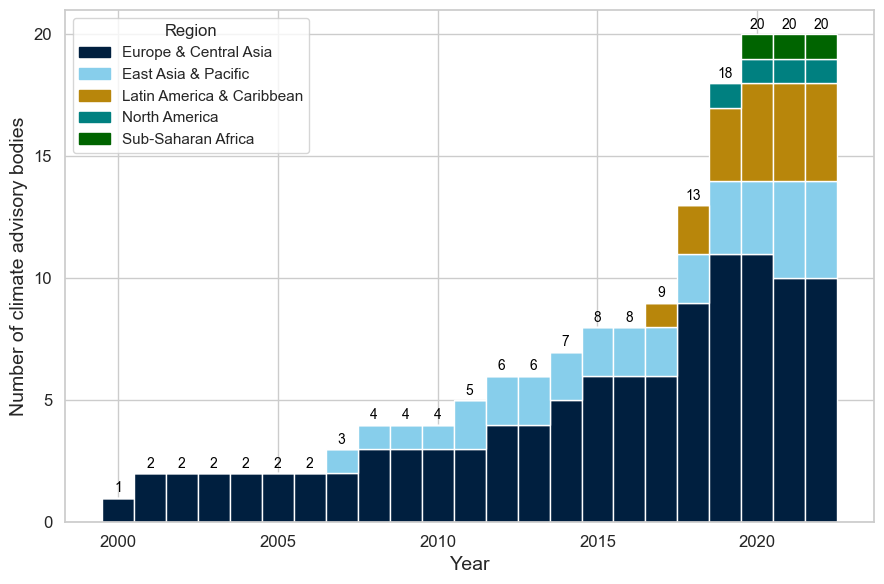

In [5]:
# Updated custom color palette
custom_palette = {
    'Europe & Central Asia': '#001f3f',  # Navy Blue
    'East Asia & Pacific': '#87CEEB',  # Sky Blue
    'Latin America & Caribbean': '#B8860B',  # Darker Yellow (Goldenrod)
    'Sub-Saharan Africa': '#006400',  # Dark Green
    'North America': '#008080',  # Teal
    'South Asia': '#2ca02c',  # Green
    'Middle East & North Africa': '#e377c2'  # Pink
}

sns.set_theme(style="whitegrid")
plt.figure(figsize=(9, 6))

# Filter dataset: Remove regions that have only zero values
filtered_df = capmf2_gov_agg[capmf2_gov_agg['obs_value1'] > 0]

# Get unique regions in filtered dataset
valid_regions = filtered_df['region'].unique()

# Ensure only valid regions are used in the palette but prevent missing key errors
filtered_palette = {region: custom_palette.get(region, '#808080') for region in capmf2_gov_agg['region'].unique()}  # Gray fallback

# Create stacked bar plot with filtered data
hist = sns.histplot(
    data=filtered_df[filtered_df['time_period'] >= 2000],
    x='time_period',
    weights='obs_value1',
    hue='region',
    multiple='stack',
    alpha=1,
    palette=filtered_palette,
    discrete=True,
    legend=True
)

# Calculate totals for each year after filtering
totals = filtered_df[filtered_df['time_period'] >= 2000].groupby('time_period')['obs_value1'].sum()

# Add labels for total number on top of the bars
for x, total in zip(totals.index, totals.values):
    plt.text(x, total + 0.1, str(int(total)), ha='center', va='bottom', fontsize=10, color='black')

# Label and styling
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of climate advisory bodies', fontsize=14)

# Ensure y-axis ticks are integers
plt.yticks(range(0, int(totals.max()) + 2, 5), fontsize=12)
plt.xticks(fontsize=12)

# Manually adding the legend if not shown automatically
handles, labels = hist.get_legend_handles_labels()
if not handles:
    from matplotlib.patches import Patch
    legend_patches = [Patch(color=filtered_palette[label], label=label) for label in valid_regions]
    plt.legend(handles=legend_patches, title='Region', loc='upper left')

plt.tight_layout()
plt.savefig(plot_dir / 'climate_governance_adoption_by_region_over_time.png', dpi=300)
plt.show()